## Using `zero-shot-classifier` and `SetFit` few-shot learning pipeline to classify complaints' categories

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch

from transformers import pipeline
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
from datasets import DatasetDict

GPU = torch.cuda.is_available()
if GPU:
    print(torch.cuda.get_device_name(0))

2023-05-15 21:25:21.951592: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 21:25:22.578894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tesla T4


### Read, clean CSV
We only need the relevant information

In [2]:
data = pd.read_csv('data/complaints.csv')

print(data.shape)

NaN_ratio = data.isnull().sum() / data.shape[0]
print(NaN_ratio[NaN_ratio > 0.2])

to_drop = ['Company public response', 'Company', 'Date received',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID']

data = data.drop(labels = to_drop, axis = 1)
data = data[data['Consumer complaint narrative'].notnull()]
data = data.drop_duplicates()

print(data.shape)

data.head(3)

(3637308, 18)
Consumer complaint narrative    0.638751
Company public response         0.549513
Tags                            0.891383
Consumer consent provided?      0.241366
Consumer disputed?              0.788756
dtype: float64
(1137659, 5)


,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative
3,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,I checked my credit report and found that some...
14,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,This is my 3rd request that I have been a vict...
15,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,"My name is XXXX XXXX, this complaint is not ma..."


In [3]:
data.describe(include = 'O').T

,count,unique,top,freq
Product,1137659,18,"Credit reporting, credit repair services, or o...",494472
Sub-product,1087233,75,Credit reporting,485241
Issue,1137659,160,Incorrect information on your report,232497
Sub-issue,931077,216,Information belongs to someone else,117431
Consumer complaint narrative,1137659,1133226,I have disputed this account and have reached ...,18


[]

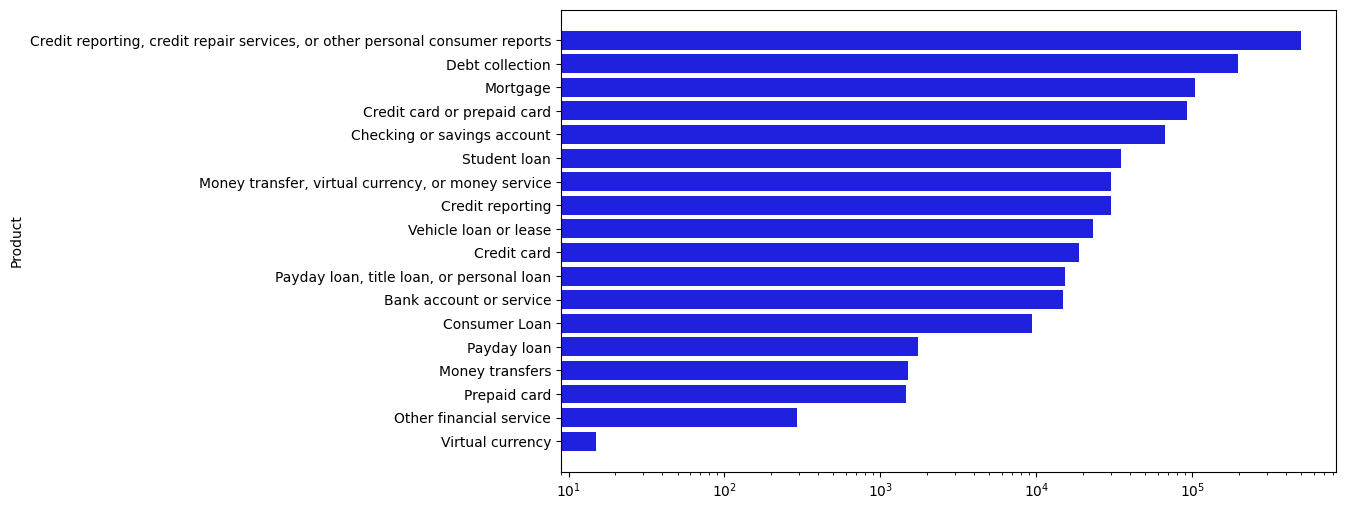

In [4]:
product_count = data['Product'].value_counts()

plt.figure(figsize = (10, 6))
sns.barplot(x = product_count.values, y = product_count.index, color = 'blue', )
plt.xscale('log')
plt.plot()

[]

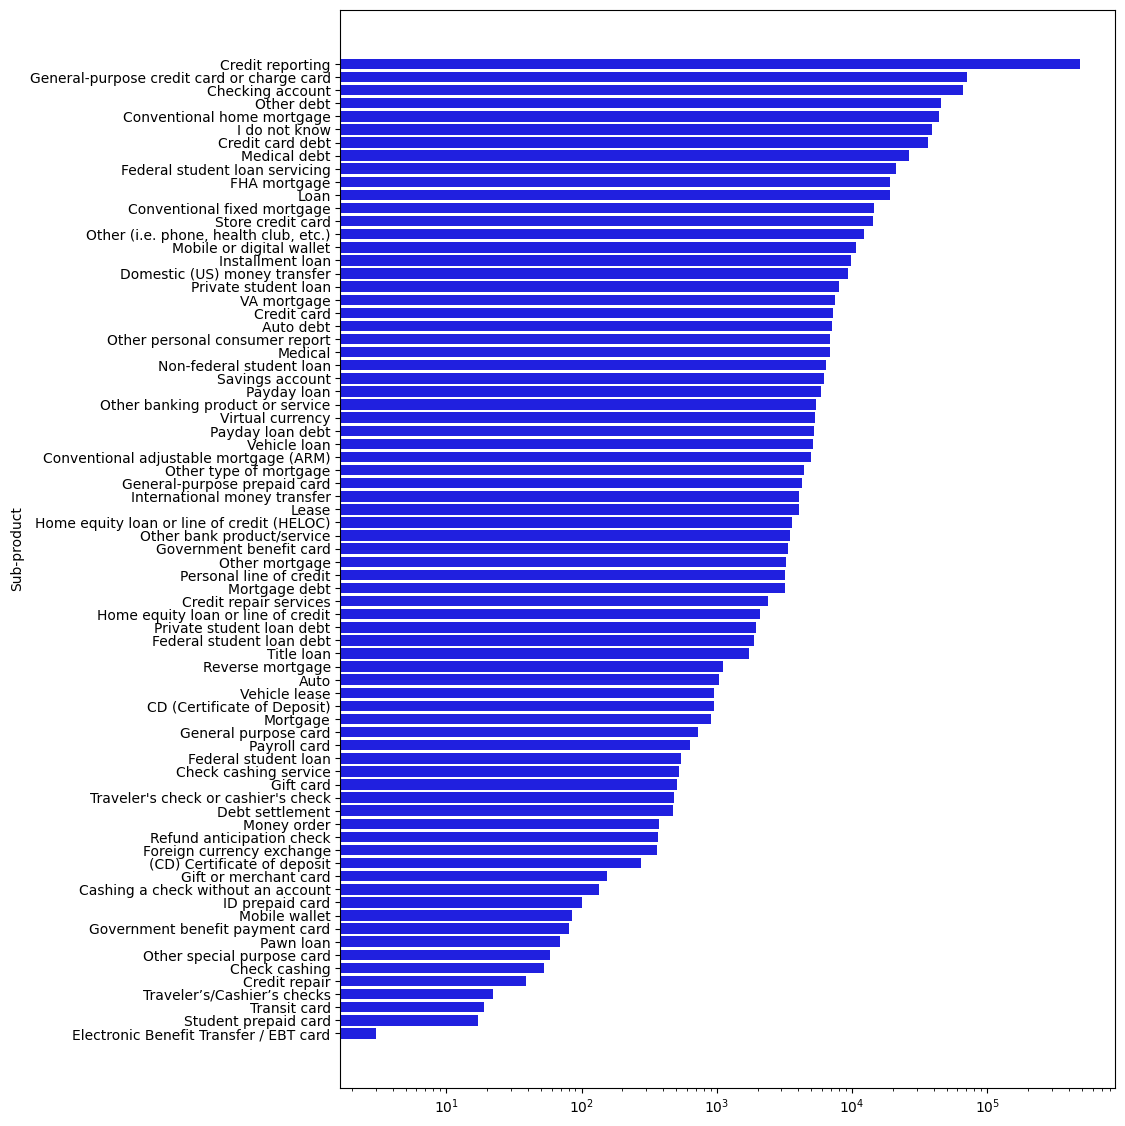

In [5]:
sub_product_count = data['Sub-product'].value_counts()

plt.figure(figsize = (10, 14))
sns.barplot(x = sub_product_count.values, y = sub_product_count.index, color = 'blue', )
plt.xscale('log')
plt.plot()

[]

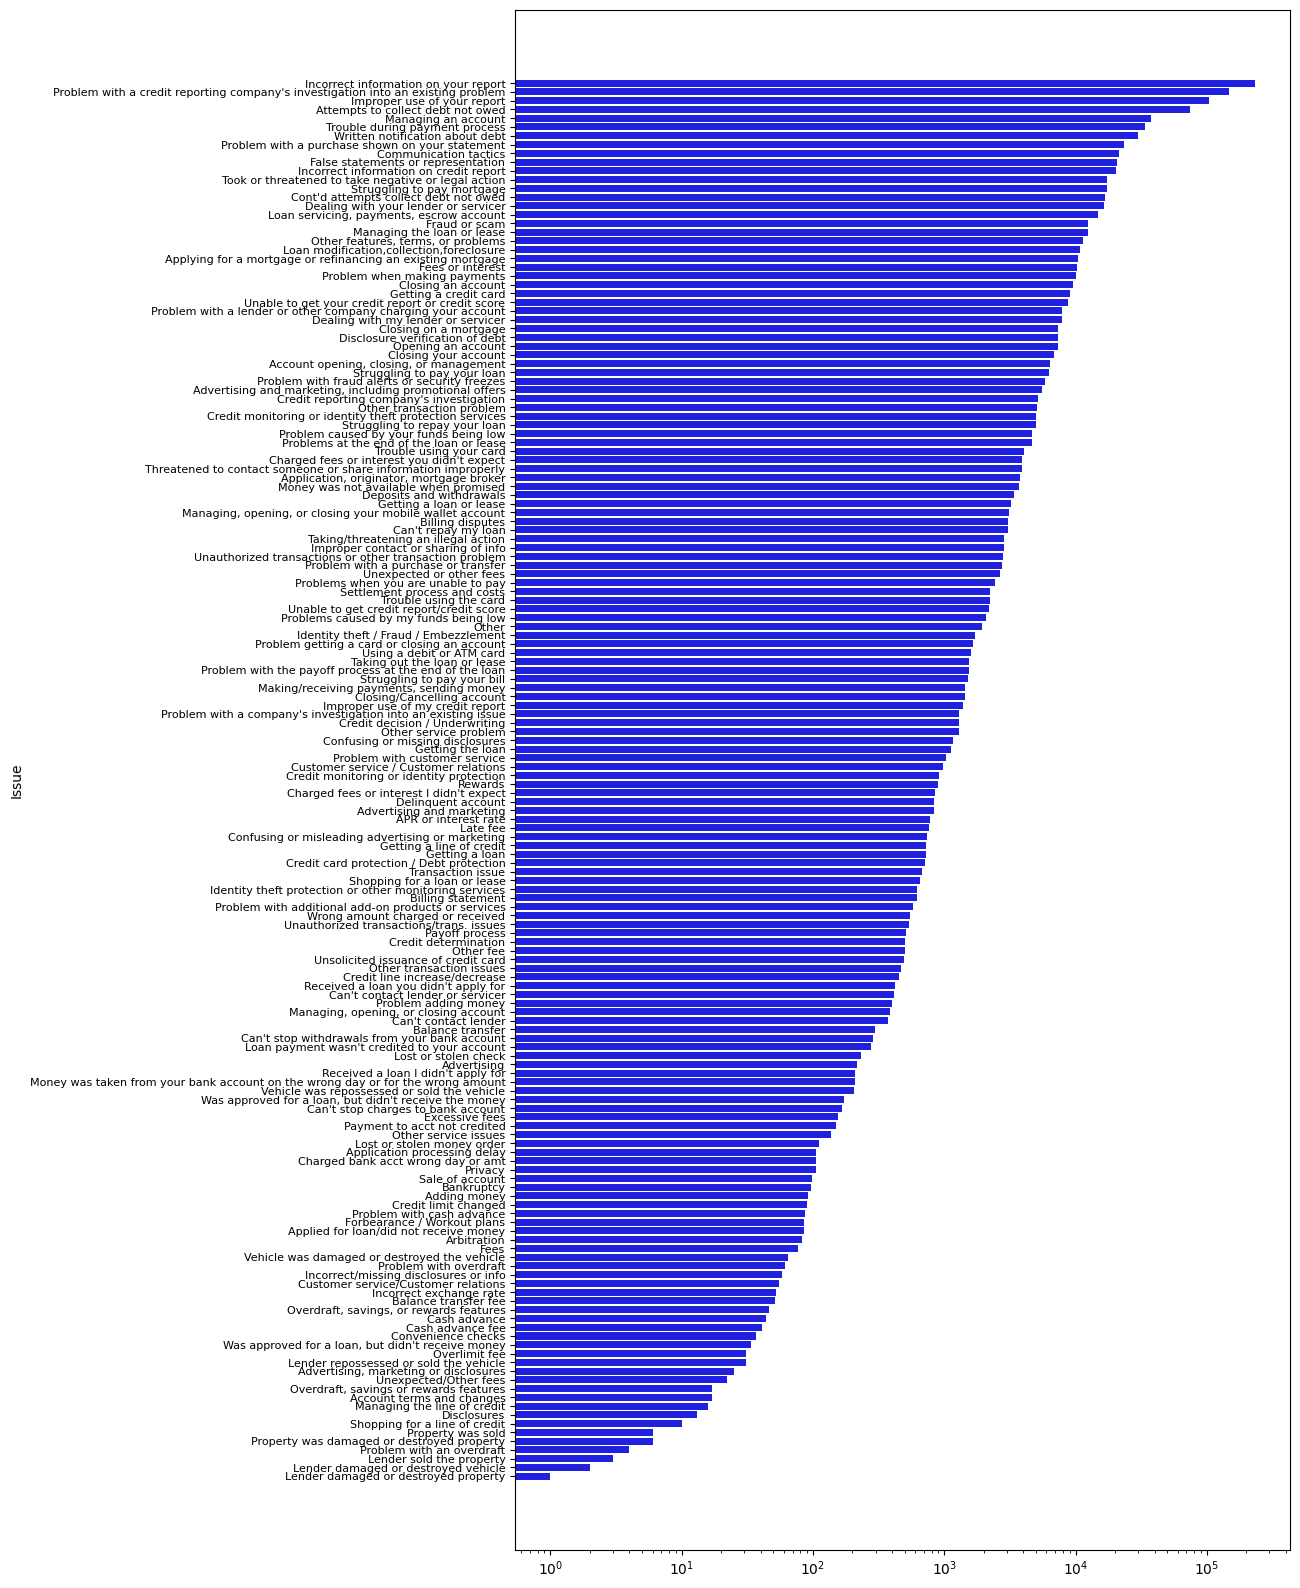

In [6]:
issue_count = data['Issue'].value_counts()

plt.figure(figsize = (10, 20))
b = sns.barplot(x = issue_count.values, y = issue_count.index, color = 'blue', )
b.set_yticklabels(issue_count.index.tolist(), fontsize = 8)
plt.xscale('log')
plt.plot()

Going forward I'll be using the `Product` as the target feature, and I will be dropping 'Virtual currency' as a label due to too few examples

- perfect for ZSL inference (not too many labels)
- peffect for FSL: 17 categories * 3-4 examples per class --> approx 60 training points

In [7]:
df = data[['Consumer complaint narrative', 'Product']].copy()
df.columns = ['input_text', 'label']

df = df[df['label'] != 'Virtual currency']

df.head(3)

,input_text,label
3,I checked my credit report and found that some...,"Credit reporting, credit repair services, or o..."
14,This is my 3rd request that I have been a vict...,"Credit reporting, credit repair services, or o..."
15,"My name is XXXX XXXX, this complaint is not ma...","Credit reporting, credit repair services, or o..."


### Splitting dataset ahead of experiment for comparability

In [8]:
# eval will be used to test FSL and to run ZSL inference
eval = df.groupby('label').sample(25)

# FSL includes the training and testing dataset for FSL (splitting will be done later)
FSL = df[~df.index.isin(eval.index)]

### Zero-Shot pipeline

Preferred models:
1. `MoritzLaurer/mDeBERTa-v3-base-mnli-xnli`
2. `MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7`

In [9]:
labels = eval.label.unique().tolist()

In [26]:
model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
classifier = pipeline("zero-shot-classification", model=model_name, device = 0)

In [30]:
example = 'There is a problem with my credit report'
ZSL_result = classifier(example, labels)

ZSL_result

{'sequence': 'There is a problem with my credit report',
 'labels': ['Credit reporting',
  'Credit reporting, credit repair services, or other personal consumer reports',
  'Bank account or service',
  'Credit card',
  'Credit card or prepaid card',
  'Other financial service',
  'Debt collection',
  'Mortgage',
  'Vehicle loan or lease',
  'Payday loan',
  'Money transfer, virtual currency, or money service',
  'Payday loan, title loan, or personal loan',
  'Money transfers',
  'Student loan',
  'Consumer Loan',
  'Prepaid card',
  'Checking or savings account'],
 'scores': [0.8278709053993225,
  0.06107757240533829,
  0.02663799189031124,
  0.023305216804146767,
  0.008707240223884583,
  0.0074394457042217255,
  0.007281098049134016,
  0.005911841988563538,
  0.0045823524706065655,
  0.0044077057391405106,
  0.0042625656351447105,
  0.004169123247265816,
  0.003285094164311886,
  0.0031370806973427534,
  0.002966398373246193,
  0.002741568721830845,
  0.0022169037256389856]}

Run on all batch

In [31]:
sequences = eval.input_text.tolist()

In [33]:
%%time
ZSL_results = classifier(sequences, labels)

CPU times: user 3min 37s, sys: 40.8 ms, total: 3min 37s
Wall time: 3min 37s


In [35]:
len(ZSL_results)

425

In [56]:
def format_ZSL_output(ZSL_predictions, labels, input_data, THRESHOLD_FILTER = 0.0):

    preds_df = [dict(zip(pred['labels'], pred['scores'])) for pred in ZSL_predictions]

    preds_df = pd.concat([input_data.reset_index(drop = True), pd.DataFrame(preds_df)], axis = 1)

    preds_df = pd.melt(preds_df, id_vars=eval.columns)\
                    .sort_values(['input_text', 'value'], ascending = [True, False])\
                    .groupby(['input_text'])\
                    .head(len(labels))\
                    .rename(columns = {'variable' : 'Value', 'value' : 'Confidence'})\
                    .sort_values(['input_text', 'Confidence'], ascending = [True, False])

    print(preds_df.shape)
    preds_df = preds_df[preds_df['Confidence'] >= THRESHOLD_FILTER]
    print(preds_df.shape)

    preds_df['ranking'] = preds_df.groupby('input_text').cumcount() + 1
    preds_df['correct'] = preds_df.apply(lambda x: 1 if x['Value'] == x['label'] else 0, axis = 1)

    return preds_df

In [57]:
ZSL_output = format_ZSL_output(ZSL_results, labels, eval)

(7225, 4)
(7225, 4)


Evaluate ZSL classifier

1.Take only the top prediction

In [64]:
top_1_results = ZSL_output[ZSL_output['ranking'] == 1]

print(classification_report(top_1_results['label'], top_1_results['Value']))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.12      0.88      0.22        25
                                                 Checking or savings account       0.00      0.00      0.00        25
                                                               Consumer Loan       0.00      0.00      0.00        25
                                                                 Credit card       0.47      0.36      0.41        25
                                                 Credit card or prepaid card       0.00      0.00      0.00        25
                                                            Credit reporting       0.22      0.68      0.33        25
Credit reporting, credit repair services, or other personal consumer reports       0.00      0.00      0.00        25
                                                       

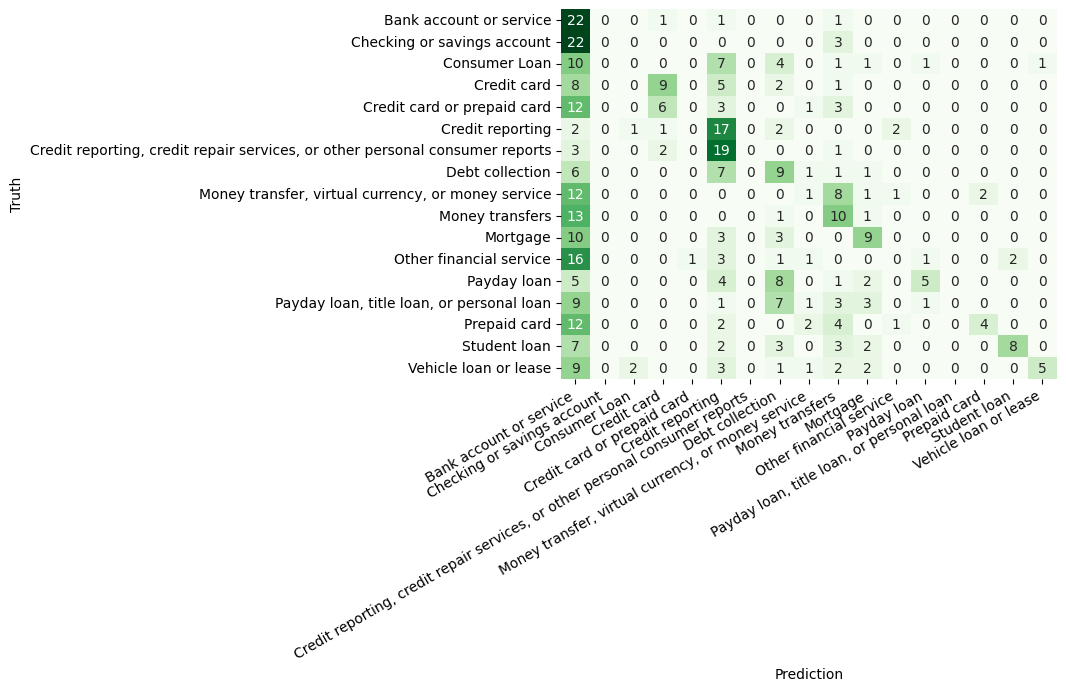

In [80]:
CM = pd.DataFrame(confusion_matrix(top_1_results['label'], top_1_results['Value'],
                              labels = labels),
                    columns = labels,
                    index = labels)

g = sns.heatmap(CM, annot = True, cbar = False, cmap = 'Greens')
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha = 'right')
plt.xlabel('Prediction')
plt.ylabel('Truth')

plt.show()

2.Now take the top-N predictions and calculate scores

In [59]:
def correct_within_N(data):
    
    N_correct_rate = {}

    for N in range(1, 10):  

        pred_firstN = data.groupby('input_text').head(N)
        correct_in_firstN = pred_firstN.groupby('input_text')['correct'].apply(lambda x: 1 if 1 in list(x) else 0)
        N_correct_rate[N] = correct_in_firstN.value_counts(normalize = True)[1]
        
    return N_correct_rate

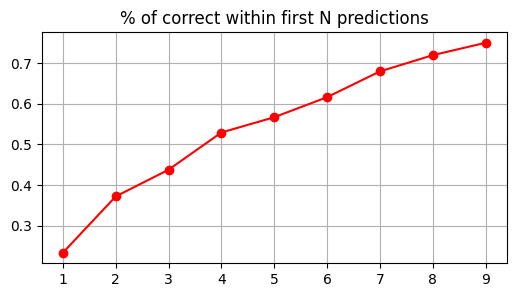

In [60]:
ZSL_correct_rates = correct_within_N(ZSL_output)

plt.figure(figsize = (6, 3))
plt.plot(list(ZSL_correct_rates.keys()), list(ZSL_correct_rates.values()), 
         color = 'red', label = 'mDeBERTa-v3-base-xnli-multilingual-nli-2mil7', marker = 'o')
plt.title('% of correct within first N predictions')
plt.grid()
plt.show()

It seems the ZSL classifier - at least the loaded model - is having difficulties with predicting the class of the complaint. Even within the top 5 predictions only 55% are correct. Now I will train a Few-Shot learner and see how it compares to ZSL

### Few-Shot pipeline

Preferred models for SetFit:
1. `all-mpnet-base-v2`
2. `multi-qa-mpnet-base-dot-v1`


Helpful guide: https://hutsons-hacks.info/few-shot-learning-with-setfit

In [9]:
FSL.label.value_counts()

label
Credit reporting, credit repair services, or other personal consumer reports    494447
Debt collection                                                                 197234
Mortgage                                                                        104236
Credit card or prepaid card                                                      92970
Checking or savings account                                                      67268
Student loan                                                                     34714
Money transfer, virtual currency, or money service                               30238
Credit reporting                                                                 29865
Vehicle loan or lease                                                            23075
Credit card                                                                      18735
Payday loan, title loan, or personal loan                                        15302
Bank account or service              

I'll use 10 samples from each category to train and 5 to evaluate

In [9]:
FSL_train_test = FSL.groupby('label').sample(15).reset_index(drop = True)
FSL_train_test.columns = ['text', 'label']
FSL_train, FSL_test = train_test_split(FSL_train_test, test_size = 1/3, stratify = FSL_train_test['label'], random_state = 42)

FSL_train = FSL_train.reset_index(drop = True)
FSL_test = FSL_test.reset_index(drop = True)

# need to remap labels to ints
LABEL_DICT = {k: v for v, k in enumerate(FSL_train.label.unique().tolist())}
LABEL_DICT_REVERSE = {v: k for k, v in LABEL_DICT.items()}
FSL_train.label = FSL_train.label.map(LABEL_DICT)
FSL_test.label = FSL_test.label.map(LABEL_DICT)

# needed to add these attributes for SetFit
FSL_train.column_names = ['text', 'label']
FSL_test.column_names = ['text', 'label']

num_class = FSL_train_test.label.nunique()
print('Number of classes:', num_class)

FSL_dataset = DatasetDict({
    'train': FSL_train, 
    'validation': FSL_test
})

Number of classes: 17


Load a pretrained `sentence-transformers` model

In [12]:
model = SetFitModel.from_pretrained('all-mpnet-base-v2', num_labels=num_class)

config.json not found in HuggingFace Hub.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Fine-tuning the base-model with few shots

In [14]:
#MODEL_NAME = 'HF_account/Preferred_Model_Name'

trainer = SetFitTrainer(
    model = model, 
    train_dataset = FSL_dataset['train'],
    eval_dataset = FSL_dataset['validation'],
    loss_class = CosineSimilarityLoss, 
    batch_size = 12, #ideally should be higher but CUDA memory is low
    num_iterations = 20,# The number of text pairs to generate for contrastive learning
    #column_mapping = {"text": "text", "label": "label"}, #error thrown: Pandas does not have rename_columns attr
    num_epochs = 2, 
    learning_rate = 2e-5
)

In [15]:
%%time 
trainer.train()

Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 298.55it/s]
***** Running training *****
  Num examples = 6800
  Num epochs = 2
  Total optimization steps = 1134
  Total train batch size = 12
Epoch: 100%|██████████| 2/2 [28:59<00:00, 869.53s/it]


CPU times: user 30min 26s, sys: 12.4 s, total: 30min 38s
Wall time: 29min 1s


In [16]:
model.save_pretrained('models')

Evaluate

In [17]:
metrics = trainer.evaluate()
metrics

***** Running evaluation *****


{'accuracy': 0.49411764705882355}

Use fine-tuned model on original eval set, so FSL can be compared to ZSL

In [19]:
model.predict_proba(['Student loan problem'])

tensor([[0.5146, 0.0276, 0.0252, 0.0324, 0.0298, 0.0458, 0.0407, 0.0258, 0.0334,
         0.0249, 0.0278, 0.0279, 0.0301, 0.0257, 0.0328, 0.0227, 0.0328]],
       dtype=torch.float64)

In [20]:
model.predict(['Student loan problem'])

tensor([0])

In [22]:
LABEL_DICT_REVERSE[0]

'Student loan'

In [27]:
%%time
sequences = eval.input_text.tolist()
FSL_predictions = model.predict_proba(sequences)

CPU times: user 5.78 s, sys: 40 µs, total: 5.78 s
Wall time: 5.17 s


In [32]:
FSL_predictions = FSL_predictions.numpy()
len(FSL_predictions)

425

In [42]:
pred_index = np.argmax(FSL_predictions, axis = 1)
pred_labels = np.vectorize(LABEL_DICT_REVERSE.get)(pred_index)
conf_scores = np.amax(FSL_predictions, axis = 1)

In [49]:
FSL_results = pd.concat([eval.reset_index(drop = True), 
                        pd.Series(pred_labels, name = 'pred'), 
                        pd.Series(conf_scores, name = 'conf')], axis = 1)

labels = eval.label.unique().tolist()

In [47]:
print(classification_report(FSL_results['label'], FSL_results['pred']))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.24      0.28      0.26        25
                                                 Checking or savings account       0.27      0.36      0.31        25
                                                               Consumer Loan       0.31      0.40      0.35        25
                                                                 Credit card       0.34      0.40      0.37        25
                                                 Credit card or prepaid card       0.27      0.24      0.26        25
                                                            Credit reporting       0.52      0.68      0.59        25
Credit reporting, credit repair services, or other personal consumer reports       0.67      0.32      0.43        25
                                                       

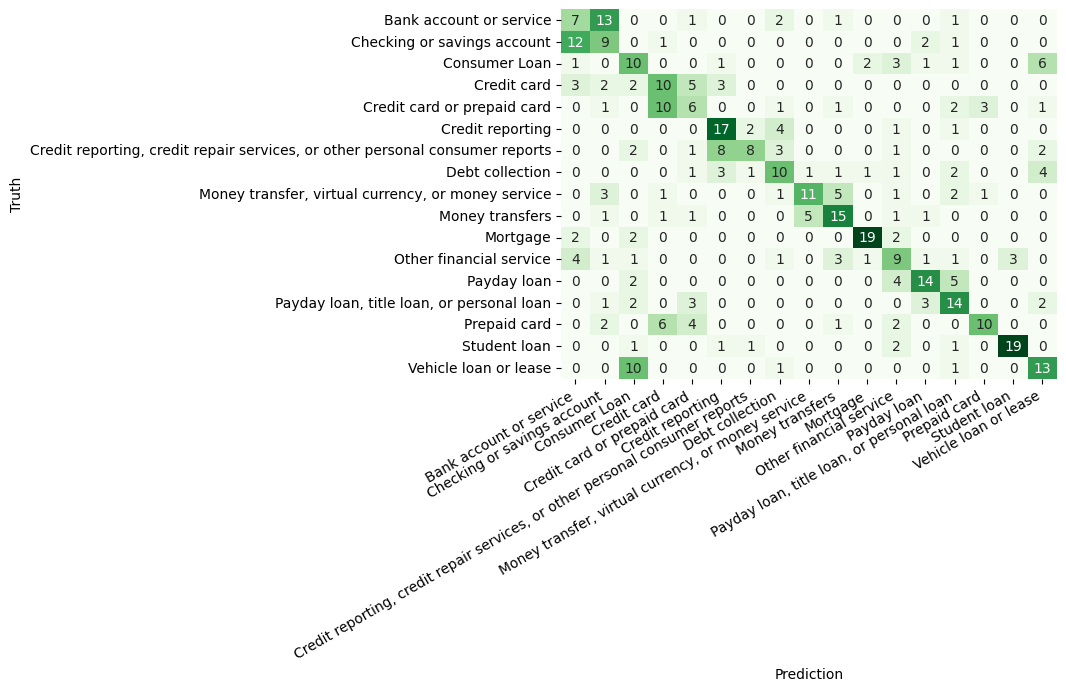

In [50]:
CM = pd.DataFrame(confusion_matrix(FSL_results['label'], FSL_results['pred'],
                              labels = labels),
                    columns = labels,
                    index = labels)

g = sns.heatmap(CM, annot = True, cbar = False, cmap = 'Greens')
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha = 'right')
plt.xlabel('Prediction')
plt.ylabel('Truth')

plt.show()